# **Homework 2**

## **2.1 Loading the MNIST dataset**

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [ ]:
( train_ds , test_ds ) , ds_info = tfds.load('mnist', split =[ 'train', 'test'], as_supervised = True , with_info = True )
print(ds_info)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1.incompleteMC4DY5',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      

**How many training/test images are there?**
* 10000 test and 60000 train images  

**What’s the image shape?**  
* (28,28,1)

**What range are pixel values in?**
* 0-255

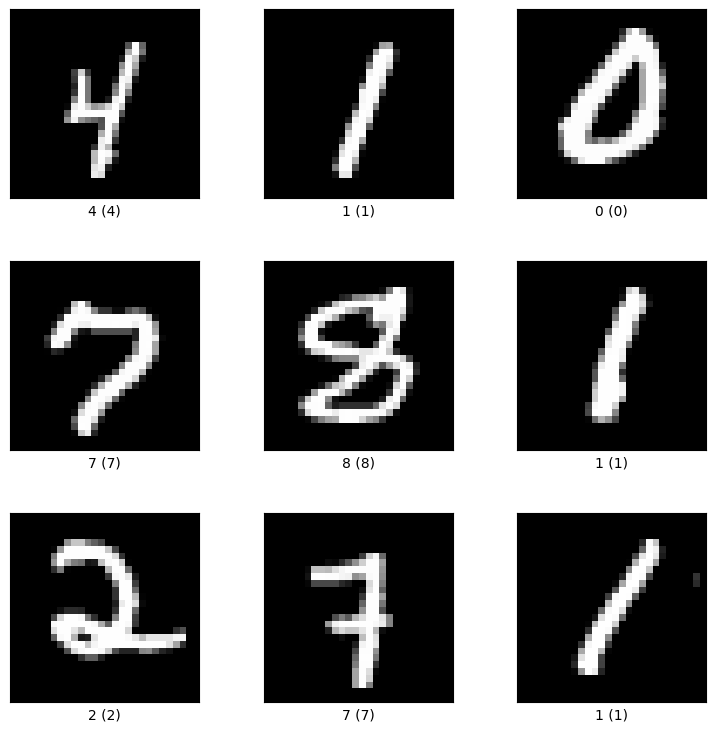

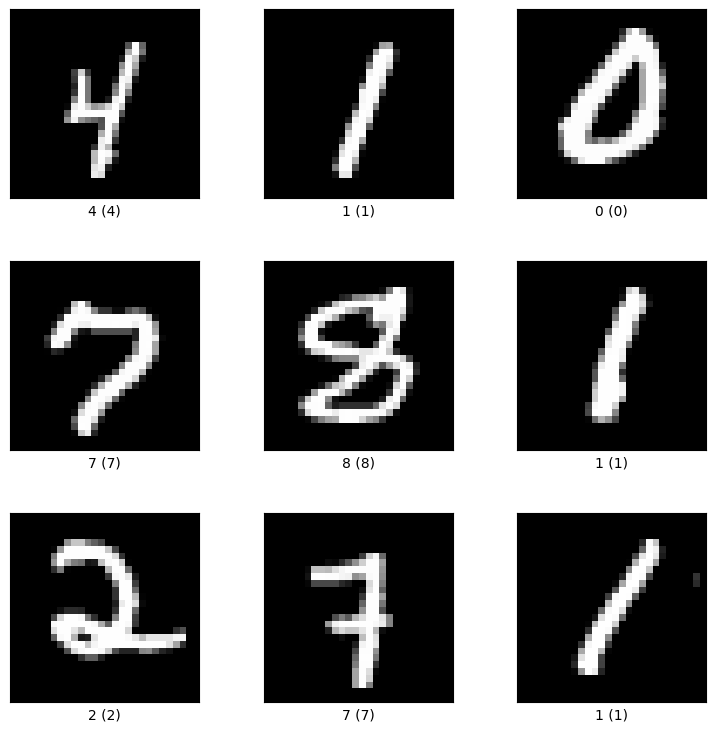

In [ ]:
tfds.show_examples(train_ds , ds_info)

## **2.2 Setting up the data pipeline**

In [ ]:
def data_prep(data):
  # batch_size = 32
  batch_size = 16
  shuffle_size = 1000
  prefetch_size = 20
  # take a dictionary and pass image and label on
  #data = data.map(lambda feature_dict: (feature_dict['image'], feature_dict['label']))
  # reshape images
  data = data.map(lambda image, label: (tf.reshape(image, (-1,)), label))
  # scale down respective pixels to range 127 & cast to float
  data = data.map(lambda image, label: ((tf.cast(image, tf.float32)/128)-1, label))
  # one hotify the labels
  data = data.map(lambda image, label: (image, tf.one_hot(label, depth=10)))
  # shuffle data and then batch of the suffled data
  data = data.shuffle(shuffle_size).batch(batch_size)
  # prefetch function, makes sure prefetch_size batches are always ready
  data = data.prefetch(prefetch_size)

  return data

## **2.3 Building a deep neural network with TensorFlow**

In [ ]:
class MNIST_Model(tf.keras.Model):

  def __init__(self, layer_sizes, output_size=10):
    super().__init__()
    self.mlp_layers = []
    # create layers
    for layer_size in layer_sizes:
        new_layer = tf.keras.layers.Dense(units=layer_size, activation='relu')
        self.mlp_layers.append(new_layer)
    # output layer
    self.output_layer = tf.keras.layers.Dense(units=output_size, activation='softmax')


  def call(self, x):
    for layer in self.mlp_layers:
      x = layer(x)
    y = self.output_layer(x)
    return y

## **2.4 Training the network**

In [ ]:
def train_loop(model, train_ds, test_ds, loss_func, optimizer, num_epochs=10):

  train_losses = []
  train_accuracies = []
  test_losses = []
  test_accuracies = []

  for epoch in range(num_epochs):


    #training
    epoch_losses = []
    epoch_accuracies = []
    for input,target in train_ds:
        loss, accuracy = train_step(model, input, target, loss_func, optimizer)
        epoch_losses.append(loss)
        epoch_accuracies.append(accuracy)

    #track training loss and accuracies
    train_losses.append(tf.reduce_mean(epoch_losses))
    train_accuracies.append(tf.reduce_mean(epoch_accuracies))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test_loop(model, test_ds, loss_func)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f' After epoch {str(epoch+1)} the accuracy is: {test_accuracies[-1]}')

  return train_losses, train_accuracies, test_losses, test_accuracies

def train_step(model, input, target, loss_function, optimizer):

  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    accuracy = np.mean(accuracy)

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return loss, accuracy

def test_loop(model, test_ds, loss_func):
  test_accuracy_agg = []
  test_loss_agg = []

  for (input, target) in test_ds:
    prediction = model(input)
    sample_test_loss = loss_func(target, prediction)
    # sample_test_accuracy hat boolean pro sample in batch (länge ist also wie batch size)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    # mean accuracy for the batch
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_agg.append(sample_test_loss.numpy())
    test_accuracy_agg.append(sample_test_accuracy)


  test_loss = tf.reduce_mean(test_loss_agg)
  test_accuracy = tf.reduce_mean(test_accuracy_agg)

  return test_loss, test_accuracy


## **2.5 Visualization**

In [ ]:
def visualization( train_losses , train_accuracies , test_losses , test_accuracies):

  xaxis = np.linspace(start=1, stop=len(train_losses), num=len(train_losses))

  # Plot the Loss
  plt.plot(xaxis, train_losses, color="red", label="Train")
  plt.plot(xaxis, test_losses, color="blue", label="Test")
  plt.title("Train vs. Test Loss")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  # Plot the Accuracy
  plt.plot(xaxis, train_accuracies, color="red", label="Train")
  plt.plot(xaxis, test_accuracies, color="blue", label="Test")
  plt.title("Train vs. Test Accuracy")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.show()

## **3 Adjusting the hyperparameters of your model**  

- learning rate  
- batch size  
- the number of layers  
- size of layers   
- optimizer

### **Base Configuration of Model:**
- learning rate: 0.001   
- batch size: 32  
- number of layers (not counting output layer): 2  
- size of layers: 256, 256
- optimizer: SGD (stochastic gradient descent)  
- epochs: 20
- loss function: Categorical cross entropy loss  
#### Results:
- Accuracy obtained: 0.943  

### **Change only learning rate to higher value:**    
- learning rate: 0.01   
- batch size: 32  
- number of layers (not counting output layer): 2  
- size of layers: 256, 256
- optimizer: SGD (stochastic gradient descent)  
- epochs: 20
- loss function: Categorical cross entropy loss  
#### Results:
- Accuracy obtained: 0.979
- plots for loss and accuracy show some overfitting
- pretty high accuracy for only changing the learning rate
- in this case it seems the lower learning rate made the newtork be stuck at a local optimum
- accuracy was at 0.97 already after epoch 9, so a smaller epoch number for faster training could also make sense  

### **Change only optimizer from SGD to Adam:**    
- learning rate: 0.001   
- batch size: 32  
- number of layers (not counting output layer): 2  
- size of layers: 256, 256
- optimizer: Adam (Adaptive Moment Estimation)
- epochs: 20
- loss function: Categorical cross entropy loss  
#### Results:  
- stronger overfitting
- starting out with hightest accuracy yet but being stuck more or less at same accuracy
- accuracy ranging 0.957 - 0.977  

### **Change optimizer from SGD to Adam and learning rate:**    
- learning rate: 0.01   
- batch size: 32  
- number of layers (not counting output layer): 2  
- size of layers: 256, 256
- optimizer: Adam (Adaptive Moment Estimation)
- epochs: 20
- loss function: Categorical cross entropy loss  
#### Results:  
- accuracy starting at 0.91 going to only 0.92/0.93
- stronger fluctuations in test accuracy and loss
- too high learning rate for that specific optimizer maybe  

### **Change optimizer from SGD to Adam and layer number and size:**    
- learning rate: 0.001   
- batch size: 32  
- number of layers (not counting output layer): 4   
- size of layers: 256, 256, 400, 200
- optimizer: Adam (Adaptive Moment Estimation)
- epochs: 20
- loss function: Categorical cross entropy loss  
#### Results:  
- accuracy of about 0.97 again
- fluctuations
- accuracy starting at 0.94 already after first epoch  

### **Change layer number and learning rate:**    
- learning rate: 0.01   
- batch size: 32  
- number of layers (not counting output layer): 4   
- size of layers: 256, 256, 256, 256
- optimizer: SGD
- epochs: 20
- loss function: Categorical cross entropy loss  
#### Results:  
- some overfitting
- accuracy of about 0.974 at the end of training  

### **Change layer number and learning rate and batch size:**    
- learning rate: 0.01   
- batch size: 16  
- number of layers (not counting output layer): 4   
- size of layers: 256, 256, 256, 256
- optimizer: SGD
- epochs: 20
- loss function: Categorical cross entropy loss  
#### Results:
- longest training yet
- accuracy of 0.98 reached


In [ ]:
# main
train_ds, test_ds = tfds.load('mnist', split =['train', 'test'], as_supervised = True)

# data
train_data = train_ds.apply(data_prep)
test_data = test_ds.apply(data_prep)

In [ ]:
# model
layer_sizes = [256,256, 256, 256]
mnistModel = MNIST_Model(layer_sizes)

# training
loss_func = tf.keras.losses.CategoricalCrossentropy()
learning_rate = 0.01
optimizer = tf.keras.optimizers.SGD(learning_rate)
#optimizer = tf.keras.optimizers.Adam(learning_rate)
num_epochs = 20
train_losses, train_accuracies, test_losses, test_accuracies = train_loop(mnistModel, train_data, test_data, loss_func, optimizer, num_epochs)

 After epoch 1 the accuracy is: 0.9483
 After epoch 2 the accuracy is: 0.9597
 After epoch 3 the accuracy is: 0.9653
 After epoch 4 the accuracy is: 0.974
 After epoch 5 the accuracy is: 0.9721
 After epoch 6 the accuracy is: 0.9743
 After epoch 7 the accuracy is: 0.9756
 After epoch 8 the accuracy is: 0.9765
 After epoch 9 the accuracy is: 0.9784
 After epoch 10 the accuracy is: 0.9771
 After epoch 11 the accuracy is: 0.9756
 After epoch 12 the accuracy is: 0.9806
 After epoch 13 the accuracy is: 0.9788
 After epoch 14 the accuracy is: 0.9796
 After epoch 15 the accuracy is: 0.9809
 After epoch 16 the accuracy is: 0.9795
 After epoch 17 the accuracy is: 0.9788
 After epoch 18 the accuracy is: 0.98
 After epoch 19 the accuracy is: 0.9781
 After epoch 20 the accuracy is: 0.9817


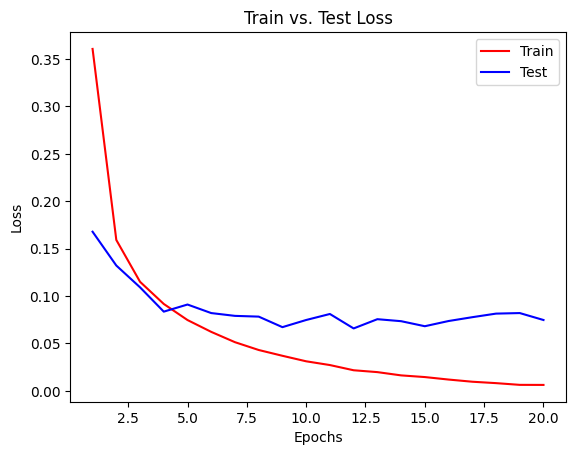

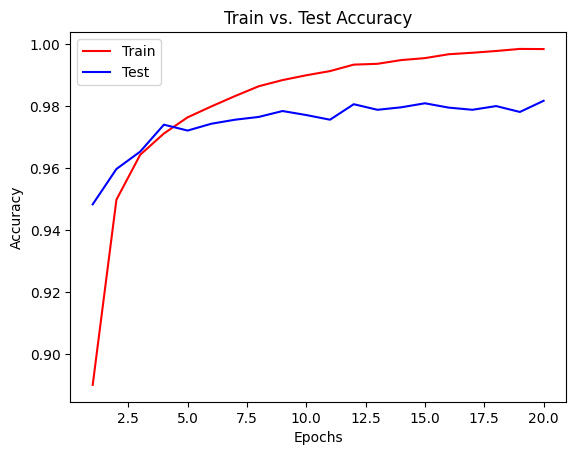

In [ ]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)